In [2]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
from scipy import stats
from scipy.stats import zscore

/Users/vaishnavverma/.matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /var/folders/gp/0qsbr0x11d315dt15fl17c940000gn/T/matplotlib-k81mpo9t because there was an issue with the default path (/Users/vaishnavverma/.matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [3]:
# Load the dataset
df_raw = pd.read_csv('../data/processed/movies_clean.csv')

# Create a copy for preprocessing
df = df_raw.copy()

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Dataset loaded successfully!
Shape: (337926, 11)
Memory usage: 114.43 MB


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337926 entries, 0 to 337925
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          337926 non-null  object 
 1   primaryTitle    337925 non-null  object 
 2   originalTitle   337925 non-null  object 
 3   titleType       337926 non-null  object 
 4   isAdult         337926 non-null  int64  
 5   startYear       337892 non-null  float64
 6   runtimeMinutes  303941 non-null  float64
 7   genres          326488 non-null  object 
 8   averageRating   337926 non-null  float64
 9   numVotes        337926 non-null  int64  
 10  decade          337926 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 28.4+ MB


In [5]:
# Check uniqueness of tconst
duplicates = df['tconst'].duplicated().sum()
print(f"Number of duplicate tconst values: {duplicates}")
print(f"Total unique tconst values: {df['tconst'].nunique()}")
print(f"Total rows: {len(df)}")

Number of duplicate tconst values: 0
Total unique tconst values: 337926
Total rows: 337926


In [27]:
# Analyze missing values
print("Missing Values Summary:")
print("=" * 60)
missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print(missing_summary.to_string(index=False))
print("\n")

# Handle missing values
# 1. Drop rows with missing primaryTitle or originalTitle (only 1 row)
df = df.dropna(subset=['primaryTitle', 'originalTitle'])

# 2. Fill missing startYear with median or drop (34 rows - minimal impact)
df = df.dropna(subset=['startYear'])

# 3. Keep missing runtimeMinutes as is (will handle in analysis if needed)
# 4. Keep missing genres as is (will handle separately if needed)

print(f"After handling missing values:")
print(f"Shape: {df.shape}")
print(f"Remaining missing values:\n{df.isnull().sum()}")

Missing Values Summary:
Empty DataFrame
Columns: [Column, Missing_Count, Missing_Percentage]
Index: []


After handling missing values:
Shape: (337891, 32)
Remaining missing values:
tconst               0
primaryTitle         0
originalTitle        0
titleType            0
isAdult              0
startYear            0
runtimeMinutes       0
genres               0
averageRating        0
numVotes             0
decade               0
primaryGenre         0
numGenres            0
logVotes             0
bayes_rating         0
runtime_bin          0
genre_Action         0
genre_Adult          0
genre_Adventure      0
genre_Animation      0
genre_Biography      0
genre_Comedy         0
genre_Crime          0
genre_Documentary    0
genre_Drama          0
genre_Family         0
genre_Fantasy        0
genre_Horror         0
genre_Other          0
genre_Romance        0
genre_Thriller       0
genre_Unknown        0
dtype: int64


In [7]:
# Handle missing genres
df['genres'] = df['genres'].fillna('Unknown')

print(f"Missing genres filled with 'Unknown'")
print(f"Remaining missing values in genres: {df['genres'].isnull().sum()}")
print(f"\nGenres value counts (top 10):")
print(df['genres'].value_counts().head(10))

Missing genres filled with 'Unknown'
Remaining missing values in genres: 0

Genres value counts (top 10):
genres
Drama                   57231
Documentary             37224
Comedy                  26883
Unknown                 11438
Comedy,Drama            10698
Drama,Romance           10197
Horror                   8364
Comedy,Romance           5932
Thriller                 5346
Comedy,Drama,Romance     5060
Name: count, dtype: int64


In [9]:
# Handle runtimeMinutes by imputing median by titleType
df['runtimeMinutes'] = df.groupby('titleType')['runtimeMinutes'].transform(lambda x: x.fillna(x.median()))

print(f"Missing runtimeMinutes after imputation: {df['runtimeMinutes'].isnull().sum()}")
print(f"\nRuntimeMinutes statistics by titleType:")
print(df.groupby('titleType')['runtimeMinutes'].describe())

Missing runtimeMinutes after imputation: 0

RuntimeMinutes statistics by titleType:
              count       mean        std  min   25%   50%    75%      max
titleType                                                                 
movie      337891.0  94.187276  167.66114  1.0  82.0  91.0  101.0  59460.0


In [10]:
# Create comprehensive data quality report
def data_quality_report(dataframe):
    """
    Generate a comprehensive data quality report
    """
    quality_df = pd.DataFrame({
        'Column': dataframe.columns,
        'Data_Type': dataframe.dtypes.values,
        'Non_Null_Count': dataframe.count().values,
        'Null_Count': dataframe.isnull().sum().values,
        'Null_Percentage': (dataframe.isnull().sum() / len(dataframe) * 100).values,
        'Unique_Values': [dataframe[col].nunique() for col in dataframe.columns],
        'Unique_Percentage': [(dataframe[col].nunique() / len(dataframe) * 100) for col in dataframe.columns]
    })
    
    quality_df = quality_df.sort_values('Null_Percentage', ascending=False).reset_index(drop=True)
    return quality_df

quality_report = data_quality_report(df)
print("\n=== DATA QUALITY REPORT ===")
print(quality_report)


=== DATA QUALITY REPORT ===
            Column Data_Type  Non_Null_Count  Null_Count  Null_Percentage  \
0           tconst    object          337891           0              0.0   
1     primaryTitle    object          337891           0              0.0   
2    originalTitle    object          337891           0              0.0   
3        titleType    object          337891           0              0.0   
4          isAdult     int64          337891           0              0.0   
5        startYear   float64          337891           0              0.0   
6   runtimeMinutes   float64          337891           0              0.0   
7           genres    object          337891           0              0.0   
8    averageRating   float64          337891           0              0.0   
9         numVotes     int64          337891           0              0.0   
10          decade     int64          337891           0              0.0   

    Unique_Values  Unique_Percentage  
0      

In [13]:
df.describe()

,isAdult,startYear,runtimeMinutes,averageRating,numVotes,decade
count,337891.000000,337891.000000,337891.000000,337891.000000,3.378910e+05,337891.000000
mean,0.014096,1996.866371,94.187276,6.139193,3.646842e+03,1992.450613
std,0.117888,26.266722,167.661140,1.380057,3.718208e+04,26.518407
min,0.000000,1894.000000,1.000000,1.000000,5.000000e+00,1890.000000
25%,0.000000,1981.000000,82.000000,5.300000,2.000000e+01,1980.000000
50%,0.000000,2007.000000,91.000000,6.200000,6.200000e+01,2000.000000
75%,0.000000,2017.000000,101.000000,7.100000,3.180000e+02,2010.000000
max,1.000000,2025.000000,59460.000000,10.000000,3.114529e+06,2020.000000


=== OUTLIER ANALYSIS ===

Ratings Distribution:
count    337891.000000
mean          6.139193
std           1.380057
min           1.000000
25%           5.300000
50%           6.200000
75%           7.100000
max          10.000000
Name: averageRating, dtype: float64
Valid rating range should be: 0-10
Ratings outside valid range: 0

Votes Distribution:
count    3.378910e+05
mean     3.646842e+03
std      3.718208e+04
min      5.000000e+00
25%      2.000000e+01
50%      6.200000e+01
75%      3.180000e+02
max      3.114529e+06
Name: numVotes, dtype: float64

99.5th percentile for numVotes: 158035.54999999952


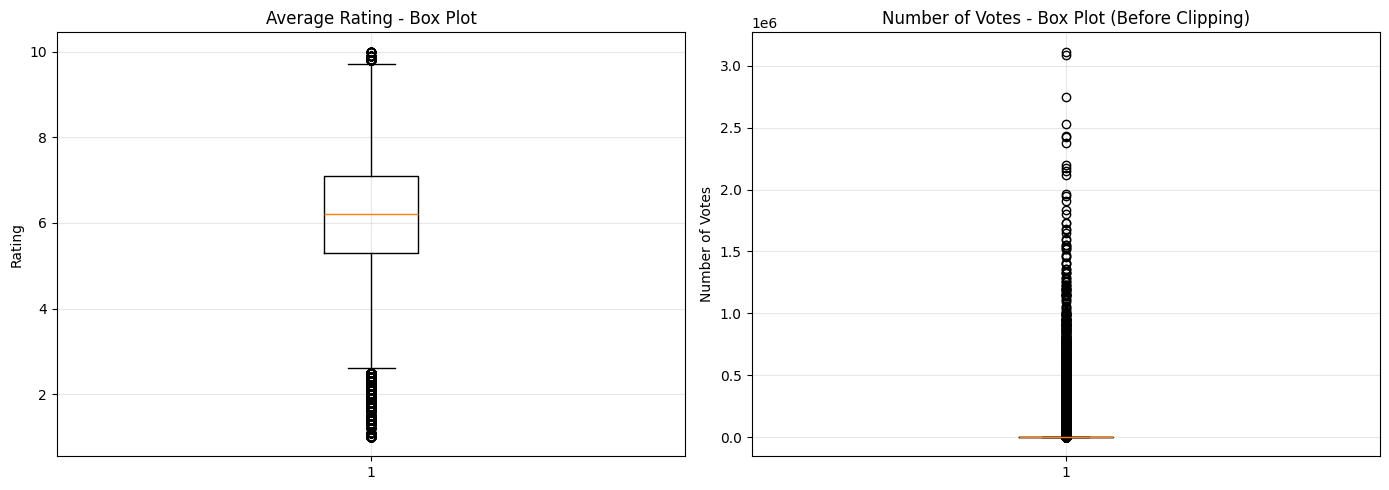


=== AFTER HANDLING OUTLIERS ===

Dataset shape: (337891, 11)

Ratings statistics:
count    337891.000000
mean          6.139193
std           1.380057
min           1.000000
25%           5.300000
50%           6.200000
75%           7.100000
max          10.000000
Name: averageRating, dtype: float64

Votes statistics:
count    337891.00000
mean       2456.20845
std       14371.32656
min           5.00000
25%          20.00000
50%          62.00000
75%         318.00000
max      158035.55000
Name: numVotes, dtype: float64


In [14]:
# Detect and handle outliers in ratings and votes

# 1. Analyze outliers before handling
print("=== OUTLIER ANALYSIS ===\n")

# Ratings analysis
print("Ratings Distribution:")
print(df['averageRating'].describe())
print(f"Valid rating range should be: 0-10")
print(f"Ratings outside valid range: {((df['averageRating'] < 0) | (df['averageRating'] > 10)).sum()}")

# Votes analysis
print("\nVotes Distribution:")
print(df['numVotes'].describe())
print(f"\n99.5th percentile for numVotes: {df['numVotes'].quantile(0.995)}")

# Visualize outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot for ratings
axes[0].boxplot(df['averageRating'])
axes[0].set_title('Average Rating - Box Plot')
axes[0].set_ylabel('Rating')
axes[0].grid(True, alpha=0.3)

# Box plot for votes (before clipping)
axes[1].boxplot(df['numVotes'])
axes[1].set_title('Number of Votes - Box Plot (Before Clipping)')
axes[1].set_ylabel('Number of Votes')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Handle outliers
# Clip votes at 99.5 percentile
df['numVotes'] = df['numVotes'].clip(upper=df['numVotes'].quantile(0.995))

# Keep only valid ratings (0-10 range)
df = df[(df['averageRating'] >= 0) & (df['averageRating'] <= 10)]

print("\n=== AFTER HANDLING OUTLIERS ===\n")
print(f"Dataset shape: {df.shape}")
print(f"\nRatings statistics:")
print(df['averageRating'].describe())
print(f"\nVotes statistics:")
print(df['numVotes'].describe())

In [15]:
# Feature Engineering
print("=== FEATURE ENGINEERING ===\n")

# 1. Primary Genre (first genre in the list)
df['primaryGenre'] = df['genres'].apply(lambda x: x.split(',')[0] if ',' in x else x)
print(f"Primary Genre created. Unique values: {df['primaryGenre'].nunique()}")

# 2. Number of Genres
df['numGenres'] = df['genres'].apply(lambda x: len(x.split(',')) if x != 'Unknown' else 0)
print(f"Number of Genres created. Range: {df['numGenres'].min()} to {df['numGenres'].max()}")

# 3. Log-transformed votes (to handle skewness)
df['logVotes'] = np.log1p(df['numVotes'])
print(f"Log Votes created. Range: {df['logVotes'].min():.2f} to {df['logVotes'].max():.2f}")

# 4. Bayesian Average Rating (weighted rating considering number of votes)
m = df['numVotes'].quantile(0.75)  # minimum votes required
C = df['averageRating'].mean()  # mean rating across all movies
df['bayes_rating'] = (df['numVotes'] / (df['numVotes'] + m) * df['averageRating']) + (m / (df['numVotes'] + m) * C)
print(f"Bayesian Rating created. Range: {df['bayes_rating'].min():.2f} to {df['bayes_rating'].max():.2f}")

# 5. Runtime bins (categorize movies by length)
df['runtime_bin'] = pd.cut(df['runtimeMinutes'], 
                            bins=[0, 60, 90, 120, 150, float('inf')],
                            labels=['Short (<60)', 'Medium (60-90)', 'Standard (90-120)', 'Long (120-150)', 'Very Long (>150)'])
print(f"Runtime bins created. Categories: {df['runtime_bin'].unique().tolist()}")

print("\n=== FEATURE ENGINEERING SUMMARY ===")
print(f"Total features: {df.shape[1]}")
print(f"\nNew features added:")
print(f"  - primaryGenre (categorical)")
print(f"  - numGenres (numeric)")
print(f"  - logVotes (numeric)")
print(f"  - bayes_rating (numeric)")
print(f"  - runtime_bin (categorical)")

print(f"\nDataset shape: {df.shape}")
print(f"\nSample of new features:")
print(df[['primaryTitle', 'primaryGenre', 'numGenres', 'logVotes', 'bayes_rating', 'runtime_bin']].head(10))

=== FEATURE ENGINEERING ===

Primary Genre created. Unique values: 28
Number of Genres created. Range: 0 to 3
Log Votes created. Range: 1.79 to 11.97
Bayesian Rating created. Range: 1.02 to 9.29
Runtime bins created. Categories: ['Short (<60)', 'Standard (90-120)', 'Medium (60-90)', 'Long (120-150)', 'Very Long (>150)']

=== FEATURE ENGINEERING SUMMARY ===
Total features: 16

New features added:
  - primaryGenre (categorical)
  - numGenres (numeric)
  - logVotes (numeric)
  - bayes_rating (numeric)
  - runtime_bin (categorical)

Dataset shape: (337891, 16)

Sample of new features:
                     primaryTitle primaryGenre  numGenres  logVotes  \
0                      Miss Jerry      Romance          1  5.442418   
1   The Corbett-Fitzsimmons Fight  Documentary          3  6.356108   
2           Soldiers of the Cross    Biography          2  4.143135   
3                        Bohemios      Unknown          0  3.178054   
4     The Story of the Kelly Gang       Action          3

In [16]:
# Categorical Encoding
print("=== CATEGORICAL ENCODING ===\n")

# 1. Encode titleType (should be only 'movie' based on quality report)
print(f"titleType unique values: {df['titleType'].unique()}")

# 2. Encode primaryGenre - limit to top genres
top_n_genres = 15
top_genres = df['primaryGenre'].value_counts().head(top_n_genres).index.tolist()
df['primaryGenre_encoded'] = df['primaryGenre'].apply(lambda x: x if x in top_genres else 'Other')

print(f"\nPrimary Genre Encoding:")
print(f"  - Original unique genres: {df['primaryGenre'].nunique()}")
print(f"  - Top {top_n_genres} genres kept: {len(top_genres)}")
print(f"  - After encoding (including 'Other'): {df['primaryGenre_encoded'].nunique()}")
print(f"\nTop genres distribution:")
print(df['primaryGenre_encoded'].value_counts())

# 3. One-hot encode primaryGenre_encoded
df_encoded = pd.get_dummies(df, columns=['primaryGenre_encoded'], prefix='genre', drop_first=False)

print(f"\n=== AFTER ONE-HOT ENCODING ===")
print(f"Total columns: {df_encoded.shape[1]}")
print(f"New genre columns added: {df_encoded.shape[1] - df.shape[1]}")

# Show the genre columns created
genre_columns = [col for col in df_encoded.columns if col.startswith('genre_')]
print(f"\nGenre columns created ({len(genre_columns)}):")
print(genre_columns)

print(f"\nFinal dataset shape: {df_encoded.shape}")
print(f"\nSample of encoded features:")
print(df_encoded[['primaryTitle', 'primaryGenre'] + genre_columns[:5]].head())

# Update df with encoded version
df = df_encoded

=== CATEGORICAL ENCODING ===

titleType unique values: ['movie']

Primary Genre Encoding:
  - Original unique genres: 28
  - Top 15 genres kept: 15
  - After encoding (including 'Other'): 16

Top genres distribution:
primaryGenre_encoded
Drama          95663
Comedy         69198
Documentary    46454
Action         34463
Crime          15953
Horror         14203
Adventure      13302
Unknown        11438
Biography       9724
Other           6721
Thriller        5373
Adult           4485
Romance         3537
Animation       3175
Family          2386
Fantasy         1816
Name: count, dtype: int64

=== AFTER ONE-HOT ENCODING ===
Total columns: 32
New genre columns added: 15

Genre columns created (16):
['genre_Action', 'genre_Adult', 'genre_Adventure', 'genre_Animation', 'genre_Biography', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_Horror', 'genre_Other', 'genre_Romance', 'genre_Thriller', 'genre_Unknown']

Final dataset shape:

=== CORRELATION ANALYSIS ===



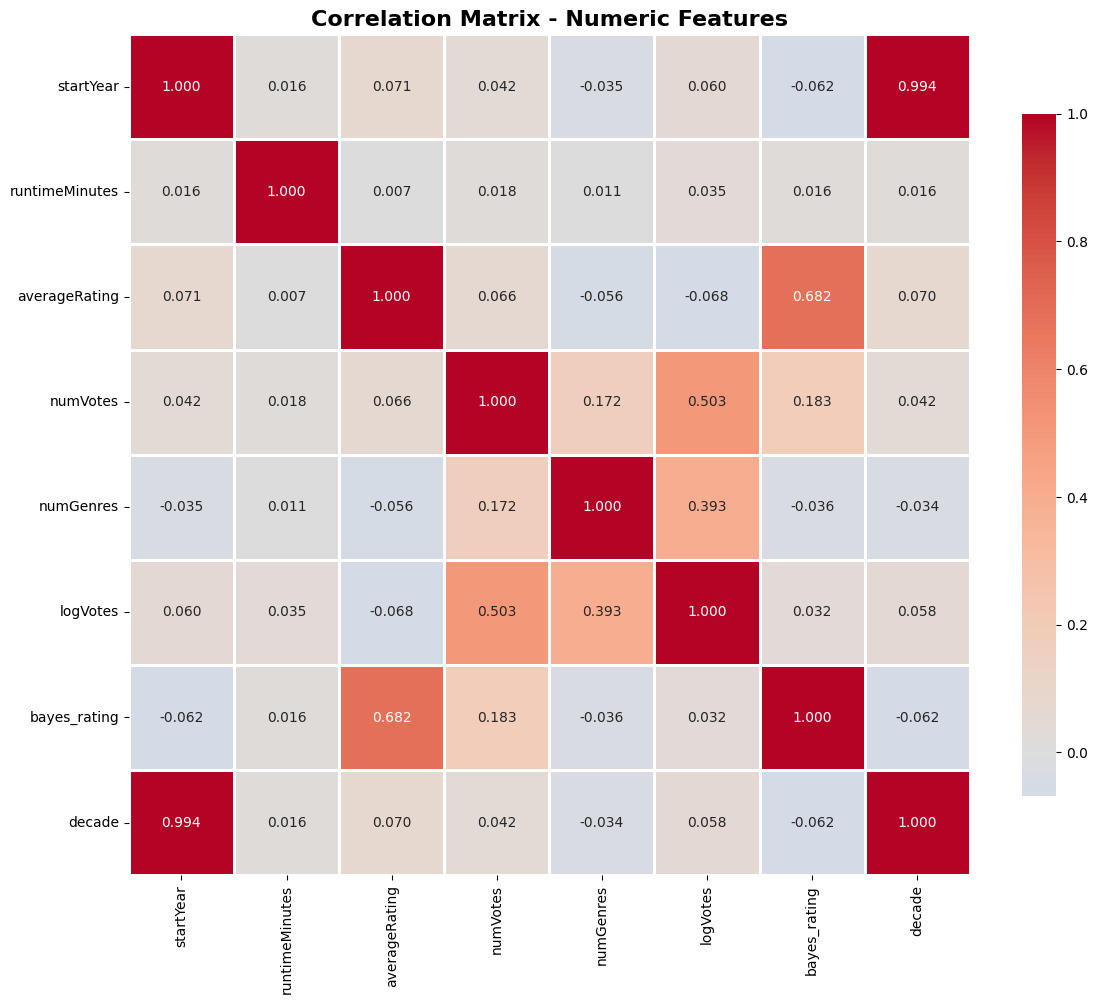


=== HIGHLY CORRELATED FEATURES (|r| > 0.7) ===

Feature 1 Feature 2  Correlation
startYear    decade     0.994251

=== CORRELATION WITH TARGET (averageRating) ===

averageRating     1.000000
bayes_rating      0.682032
startYear         0.071016
decade            0.070396
numVotes          0.066322
runtimeMinutes    0.006990
numGenres        -0.055690
logVotes         -0.067858
Name: averageRating, dtype: float64

=== FEATURE SELECTION RECOMMENDATIONS ===

Based on correlation analysis:
1. High multicollinearity detected between:
   - startYear & decade: r = 0.994

2. Consider keeping one feature from each highly correlated pair
3. Features with strongest correlation to averageRating:
   - bayes_rating: r = 0.682
   - startYear: r = 0.071
   - decade: r = 0.070


In [17]:
# Correlation Analysis
print("=== CORRELATION ANALYSIS ===\n")

# Select numeric features for correlation analysis
numeric_features = ['startYear', 'runtimeMinutes', 'averageRating', 'numVotes', 
                   'numGenres', 'logVotes', 'bayes_rating', 'decade']

# Calculate correlation matrix
correlation_matrix = df[numeric_features].corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Numeric Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Identify highly correlated pairs (|correlation| > 0.7, excluding diagonal)
print("\n=== HIGHLY CORRELATED FEATURES (|r| > 0.7) ===\n")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', 
                                                              key=abs, 
                                                              ascending=False)
    print(high_corr_df.to_string(index=False))
else:
    print("No feature pairs with |correlation| > 0.7 found.")

# Correlation with target variable (averageRating)
print("\n=== CORRELATION WITH TARGET (averageRating) ===\n")
target_corr = correlation_matrix['averageRating'].sort_values(ascending=False)
print(target_corr)

# Feature selection recommendations
print("\n=== FEATURE SELECTION RECOMMENDATIONS ===\n")
print("Based on correlation analysis:")
print("1. High multicollinearity detected between:")
for pair in high_corr_pairs:
    print(f"   - {pair['Feature 1']} & {pair['Feature 2']}: r = {pair['Correlation']:.3f}")
print("\n2. Consider keeping one feature from each highly correlated pair")
print("3. Features with strongest correlation to averageRating:")
top_features = target_corr.drop('averageRating').head(3)
for feature, corr_value in top_features.items():
    print(f"   - {feature}: r = {corr_value:.3f}")

In [26]:
# Save the processed dataset
print("=== SAVING PROCESSED DATASET ===\n")

# Define output path
output_path = "../data/processed/imdb_movies_processed.csv"
# Save to CSV
df.to_csv(output_path, index=False)

print(f"✓ Processed dataset saved successfully!")
print(f"  Path: {output_path}")
print(f"  Shape: {df.shape}")
print(f"  File size: {pd.read_csv(output_path).memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Summary of preprocessing steps
print("\n=== PREPROCESSING SUMMARY ===")
print(f"Original dataset shape: {df_raw.shape}")
print(f"Final dataset shape: {df.shape}")
print(f"Rows removed: {df_raw.shape[0] - df.shape[0]}")
print(f"Features added: {df.shape[1] - df_raw.shape[1]}")
print(f"\nNew features created:")
print(f"  - primaryGenre, numGenres, logVotes")
print(f"  - bayes_rating, runtime_bin")
print(f"  - 16 one-hot encoded genre columns")
print(f"\nData quality improvements:")
print(f"  - Missing values handled")
print(f"  - Outliers clipped/removed")
print(f"  - Categorical features encoded")
print(f"  - Multicollinearity identified (startYear & decade: r=0.994)")

=== SAVING PROCESSED DATASET ===

✓ Processed dataset saved successfully!
  Path: ../data/processed/imdb_movies_processed.csv
  Shape: (337891, 32)
  File size: 166.20 MB

=== PREPROCESSING SUMMARY ===
Original dataset shape: (337926, 11)
Final dataset shape: (337891, 32)
Rows removed: 35
Features added: 21

New features created:
  - primaryGenre, numGenres, logVotes
  - bayes_rating, runtime_bin
  - 16 one-hot encoded genre columns

Data quality improvements:
  - Missing values handled
  - Outliers clipped/removed
  - Categorical features encoded
  - Multicollinearity identified (startYear & decade: r=0.994)


In [ ]:
# Save the processed dataset
print("=== SAVING PROCESSED DATASET ===\n")

# Define output path
output_path = "../data/processed/imdb_movies_processed.csv"
# Save to CSV
df.to_csv(output_path, index=False)

print(f"✓ Processed dataset saved successfully!")
print(f"  Path: {output_path}")
print(f"  Shape: {df.shape}")
print(f"  File size: {pd.read_csv(output_path).memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Summary of preprocessing steps
print("\n=== PREPROCESSING SUMMARY ===")
print(f"Original dataset shape: {df_raw.shape}")
print(f"Final dataset shape: {df.shape}")
print(f"Rows removed: {df_raw.shape[0] - df.shape[0]}")
print(f"Features added: {df.shape[1] - df_raw.shape[1]}")
print(f"\nNew features created:")
print(f"  - primaryGenre, numGenres, logVotes")
print(f"  - bayes_rating, runtime_bin")
print(f"  - 16 one-hot encoded genre columns")
print(f"\nData quality improvements:")
print(f"  - Missing values handled")
print(f"  - Outliers clipped/removed")
print(f"  - Categorical features encoded")
print(f"  - Multicollinearity identified (startYear & decade: r=0.994)")